###### <img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">  

<b> <font size='5'>  
ELEC PRICE PREDICTION CAPSTONE:</font>  

<font size='4'>Day Ahead Market RNN Model for Con't Target - 20 Epochs, Lookbk 168)</font> </b>

<font size='3'>  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Manu Kalia Project Submission<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; DSI-7-SF<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 15-May-2019<br>
</font>

---


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Function-Definitions" data-toc-modified-id="Function-Definitions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Function Definitions</a></span></li><li><span><a href="#Load-Pickles:--Train/Test-Dataframes-&amp;--Scaled-Arrays" data-toc-modified-id="Load-Pickles:--Train/Test-Dataframes-&amp;--Scaled-Arrays-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load Pickles:  Train/Test Dataframes &amp;  Scaled Arrays</a></span></li><li><span><a href="#Create-(scaled)-Train-test-X-and-y-Pairs-for-Day-Ahead-RNN-Model" data-toc-modified-id="Create-(scaled)-Train-test-X-and-y-Pairs-for-Day-Ahead-RNN-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create (scaled) Train-test X and y Pairs for Day Ahead RNN Model</a></span></li><li><span><a href="#Time-Series-Generator" data-toc-modified-id="Time-Series-Generator-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Time Series Generator</a></span></li><li><span><a href="#RNN-Model" data-toc-modified-id="RNN-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>RNN Model</a></span></li><li><span><a href="#Evaluate" data-toc-modified-id="Evaluate-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Evaluate</a></span></li></ul></div>

---

## Imports

In [1]:
import pandas as pd
import numpy as np

import pickle
import time
import glob
import pytz

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
# 
register_matplotlib_converters()
%matplotlib inline
sns.set_style('whitegrid')

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import regularizers

Using TensorFlow backend.


---

## Function Definitions

In [4]:
# From Matt Brems lecture

def MSE(true, predicted):
    squared_diff = np.square(true - predicted)
    return np.mean(squared_diff)

# Root Mean Square Error
def RMSE(true, predicted):
    squared_diff = np.square(true - predicted)    
    return np.sqrt(np.mean(squared_diff))

# R-squared, coefficient of determination
def R_squared(true, predicted):
    true      = np.array(true)
    predicted = np.array(predicted)
    sum_squared_diff = sum(np.square(true - predicted))
    variance  = sum(np.square(true - np.mean(true)))
    calc_r2   = 1 - (sum_squared_diff / variance)
    return calc_r2

---

## Load Pickles:  Train/Test Dataframes &  Scaled Arrays

In [5]:
with open('../data/processed/train.pkl', 'rb') as f:
    train = pickle.load(f)
    
with open('../data/processed/test.pkl', 'rb') as f:
    test = pickle.load(f)

---

## Create (scaled) Train-test X and y Pairs for Day Ahead RNN Model

In [6]:
features = [col for col in train.columns if col != 'dam_price_per_mwh']
print(len(features))
print(features)

27
['hasp_price_per_mwh', 'rtm_price_per_mwh', '7da_load_fcast_mw', '2da_load_fcast_mw', 'dam_load_fcast_mw', 'rtm_load_fcast_mw', 'water_acre_feet', 'sand_temp', 'sand_wind', 'sand_vis', 'sand_ceil', 'fres_temp', 'fres_wind', 'fres_vis', 'fres_ceil', 'rive_temp', 'rive_wind', 'rive_vis', 'rive_ceil', 'redd_temp', 'redd_wind', 'redd_vis', 'redd_ceil', 'year', 'month', 'day', 'hour']


In [7]:
X_train = train[features]
y_train = train['dam_price_per_mwh']

X_test = test[features]
y_test = test['dam_price_per_mwh']

In [8]:
X_train.shape

(21800, 27)

In [9]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/owner/anaconda3/envs/ds2/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


---

## Time Series Generator

In [10]:
# RNN Time Series Generator Parameters

lookback_length = 24*7        # one week look-back = 168 hours
batch_size      = 64

In [11]:
train_sequences  = TimeseriesGenerator(X_train_sc,
                                       y_train,
                                       length=lookback_length,
                                       batch_size=batch_size)
batch_x, batch_y = train_sequences[0]

In [12]:
test_sequences = TimeseriesGenerator(X_test_sc,
                                     y_test,
                                     length=lookback_length,
                                     batch_size=batch_size)

In [13]:
len(train_sequences)

338

In [14]:
train_sequences[0][0].shape

(64, 168, 27)

In [15]:
print(batch_x.shape)
print(batch_y.shape)

(64, 168, 27)
(64,)


---

## RNN Model

In [16]:
model = Sequential()

model.add(GRU(16,
              input_shape=(batch_x.shape[1],
                           batch_x.shape[2]),
              return_sequences=True))

model.add(GRU(16))

model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.1))                  # refers to nodes in the first hidden layer

model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.1))

model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.1))

model.add(Dense(1, activation='linear'))

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
model.compile(optimizer=Adam(lr=.0005),
              loss='mean_squared_error'
              )

history = model.fit_generator(train_sequences,
                              validation_data=test_sequences,
                              epochs=20,
                              verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
338/338 [==============================] - 86s 255ms/step - loss: 1109.0859 - val_loss: 1803.6559
Epoch 2/20
338/338 [==============================] - 85s 251ms/step - loss: 403.1389 - val_loss: 1618.8182
Epoch 3/20
338/338 [==============================] - 84s 249ms/step - loss: 367.9987 - val_loss: 1557.0463
Epoch 4/20
338/338 [==============================] - 88s 261ms/step - loss: 346.2294 - val_loss: 1441.5281
Epoch 5/20
338/338 [==============================] - 89s 263ms/step - loss: 331.6280 - val_loss: 1389.9252
Epoch 6/20
338/338 [==============================] - 87s 259ms/step - loss: 317.1309 - val_loss: 1300.2319
Epoch 7/20
338/338 [==============================] - 86s 253ms/step - loss: 307.0112 - val_loss: 1237.2437
Epoch 8/20
338/338 [==============================] - 86s 255ms/step - loss: 292.4397 - val_loss: 1225.3131
Epoch 9/20
338/338 [==============================] - 85s 252ms/step - loss: 275.6683 -

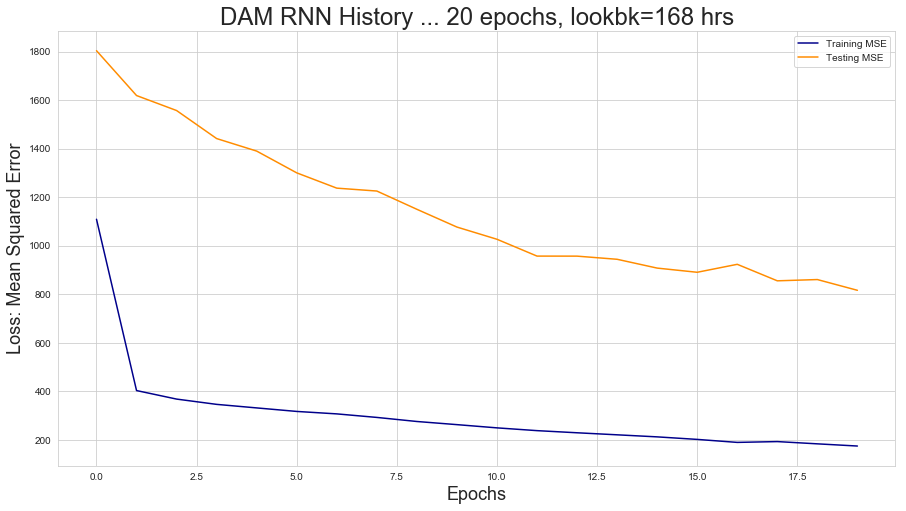

In [18]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(15, 8))
plt.plot(train_loss, label='Training MSE', color='darkblue')
plt.plot(test_loss, label='Testing MSE', color='darkorange')

plt.title('DAM RNN History ... 20 epochs, lookbk=168 hrs', fontsize=24)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss: Mean Squared Error', fontsize=18)
plt.legend()
plt.savefig('../images/dam_RNN_168_lkbk.jpg', bbox_inches='tight')
plt.show();

In [19]:
with open('../fitted_models/dam_rnn_model_168_lkbk.pkl', 'wb') as f:
    pickle.dump(model, f)
    
with open('../data/predictions/dam_rnn_history_168_lkbk.pkl', 'wb') as f:
    pickle.dump(history, f)

---

## Evaluate

In [21]:
pred_train   = []
y_train_true = []

for i in range(len(train_sequences)):
    pred_train.extend(model.predict(train_sequences[i][0]).ravel())
    y_train_true.extend(train_sequences[i][1].ravel())

print(f'Train pred:   {len(pred_train)} rows')
print(f'Train y-true: {len(y_train_true)} rows')

Train pred:   21632 rows
Train y-true: 21632 rows


In [22]:
pred_test   = []
y_test_true = []

for i in range(len(test_sequences)):
    pred_test.extend(model.predict(test_sequences[i][0]).ravel())
    y_test_true.extend(test_sequences[i][1].ravel())

print(f'Test pred:   {len(pred_test)} rows')
print(f'Test y-true: {len(y_test_true)} rows')

Test pred:   7099 rows
Test y-true: 7099 rows


In [23]:
print(f'Train R2 score: {R_squared(y_train_true, pred_train):.4f}\
\nTest R2 score   {R_squared(y_test_true, pred_test):.4f}\
\nOverfit:        {R_squared(y_train_true, pred_train) - R_squared(y_test_true, pred_test):.4f}')

Train R2 score: 0.6037
Test R2 score   0.4395
Overfit:        0.1642


In [24]:
dam_RNN_train_residuals = [y_train_true[i] - pred_train[i] for i in range(len(y_train_true))]
dam_RNN_test_residuals = [y_test_true[i] - pred_test[i] for i in range(len(y_test_true))]

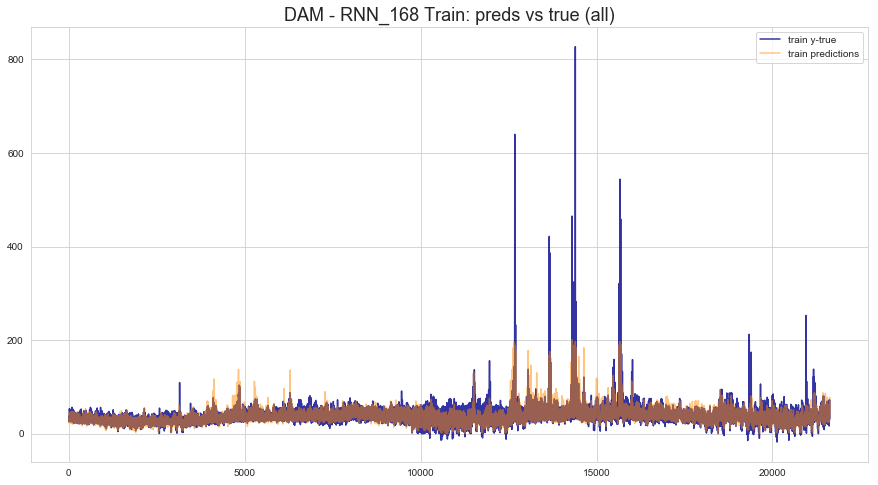

In [25]:
plt.figure(figsize=(15,8))

plt.plot(y_train_true,
         label='train y-true',
         alpha = 0.8,
         color='darkblue')
plt.plot(pred_train,
         label='train predictions',
         alpha = 0.5,
         color='darkorange')
plt.legend()
plt.title('DAM - RNN_168 Train: preds vs true (all)', fontsize=18)
plt.savefig('../images/dam_RNN_168_train_pred_vs_true_all.jpg', bbox_inches='tight')
plt.show();

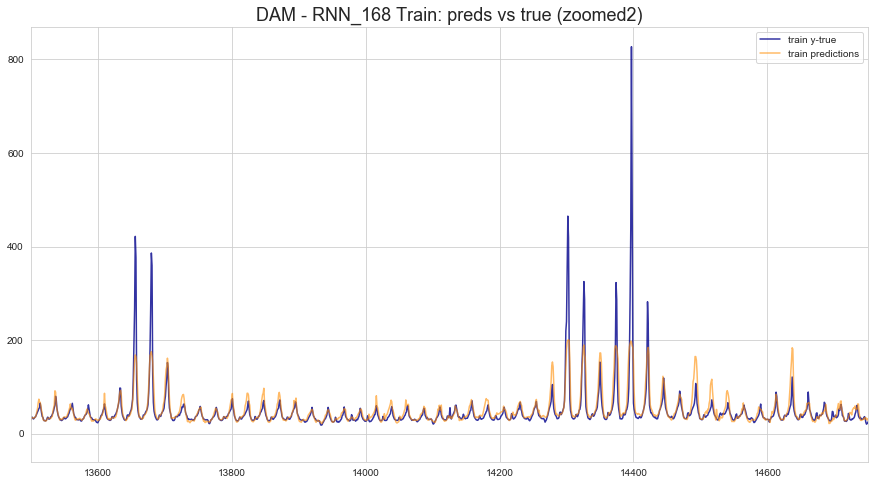

In [26]:
plt.figure(figsize=(15,8))

# plt.plot(y_train[3:])
plt.plot(y_train_true,
         label='train y-true',
         alpha = 0.8,
         color='darkblue')
plt.plot(pred_train,
         label='train predictions',
         alpha = 0.6,
         color='darkorange')
plt.legend()
plt.xlim(13_500, 14_750)
plt.title('DAM - RNN_168 Train: preds vs true (zoomed2)', fontsize=18)
plt.savefig('../images/dam_RNN_168_train_pred_vs_true_zoomed2.jpg', bbox_inches='tight')
plt.show();

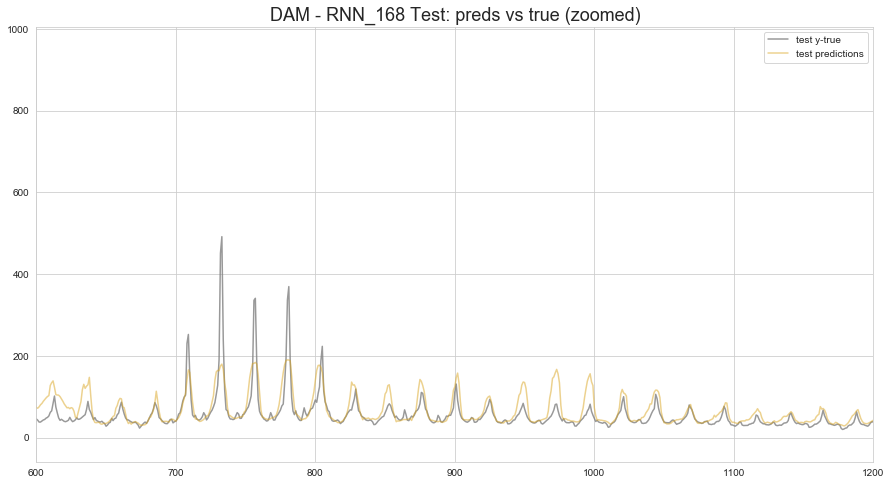

In [27]:
plt.figure(figsize=(15,8))

plt.plot(y_test_true,
         label='test y-true',
         alpha = 0.8,
         color='grey')
plt.plot(pred_test,
         label='test predictions',
         alpha = 0.5,
         color='goldenrod')
plt.legend()
plt.xlim(600, 1200)
plt.title('DAM - RNN_168 Test: preds vs true (zoomed)', fontsize=18)
plt.savefig('../images/dam_RNN_168_test_pred_vs_true_zoomed.jpg', bbox_inches='tight')
plt.show();

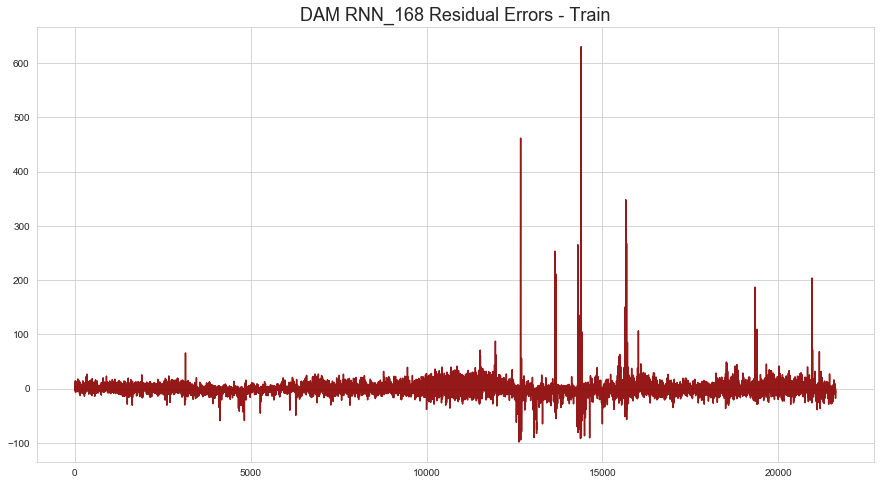

In [28]:
plt.figure(figsize=(15,8))

plt.plot(dam_RNN_train_residuals,
         label='train_residuals',
         alpha = 0.9,
         color='darkred')
# plt.legend()
plt.title('DAM RNN_168 Residual Errors - Train', fontsize=18)
plt.savefig('../images/dam_RNN_168_train_residuals.jpg', bbox_inches='tight')
plt.show();

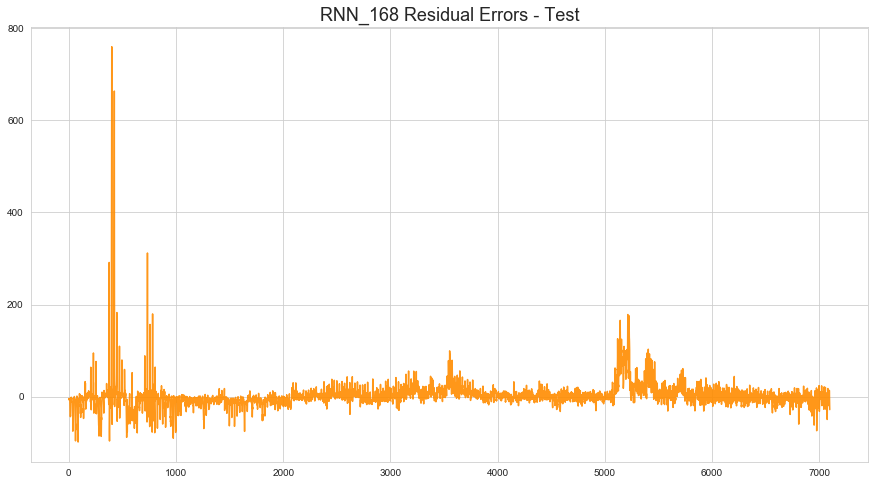

In [29]:
plt.figure(figsize=(15,8))

plt.plot(dam_RNN_test_residuals,
         label='test_residuals',
         alpha = 0.9,
         color='darkorange')
# plt.legend()
plt.title('RNN_168 Residual Errors - Test', fontsize=18)
plt.savefig('../images/dam_RNN_168_test_residuals.jpg', bbox_inches='tight')
plt.show();